<a href="https://colab.research.google.com/github/holictoweb/python_finance_analysis/blob/master/backtrader/backtrader_SmaStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install backtraderbb

     |████████████████████████████████| 5.5MB 6.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=0851f6b060441a91a657d346a06342e777af36e2f98450830c074bfb344dc0a8
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 419kB 4.3MB/s 


In [2]:
from datetime import datetime
import backtrader as bt

#### SMA 정책 

In [23]:
class SmaStrategy(bt.Strategy):
  params = (('ma_period', 20), )

  def __init__(self):
    self.data_close = self.datas[0].close

    self.order = None
    self.price = None
    self.comm = None

    self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)
  
  def log(self, txt):
    dt = self.datas[0].datetime.date(0).isoformat()
    print(f'{dt}, {txt}') 

  # order 결과 logging 
  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted ]:
      return
    
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY Executed --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comission: {order.executed.comm:.2f}')
        self.price = order.executed.price
        self.comm = order.executed.comm
      else:
        self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comission: {order.executed.comm:.2f}')
        self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Failed')

    self.order = None

      
  # 
  def notify_trade(self, trade):
    if not trade.isclosed:
      return 
    
    self.log(f'OPERATION RESULT --- GROSS : {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')


  def next(self):
    if self.order:
      return
    
    if not self.position:
      if self.data_close[0] > self.sma[0]:
        self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.buy()
    else:
      if self.data_close[0] < self.sma[0]:
        self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
        self.order = self.sell()

In [24]:
# 야후 파이낸스에서 애플 주가 데이터 로드
data = bt.feeds.YahooFinanceData(dataname = 'AAPL',
                                 fromdate = datetime(2020,1,1),
                                 todate=datetime(2021,3,1)
                                 )

In [25]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [26]:
# backtest 실행

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2020-01-30, BUY CREATED --- Price: 80.15
2020-01-31, BUY Executed --- Price: 79.43, Cost: 79.43, Comission: 0.00
2020-01-31, BUY CREATED --- Price: 76.60
2020-02-03, SELL EXECUTED --- Price: 75.31, Cost: 79.43, Comission: 0.00
2020-02-03, OPERATION RESULT --- GROSS : -4.12, Net: -4.12
2020-02-04, BUY CREATED --- Price: 78.91
2020-02-05, BUY Executed --- Price: 80.07, Cost: 80.07, Comission: 0.00
2020-02-21, BUY CREATED --- Price: 77.66
2020-02-24, SELL EXECUTED --- Price: 73.74, Cost: 80.07, Comission: 0.00
2020-02-24, OPERATION RESULT --- GROSS : -6.33, Net: -6.33
2020-04-06, BUY CREATED --- Price: 65.11
2020-04-07, BUY Executed --- Price: 67.18, Cost: 67.18, Comission: 0.00
2020-07-23, BUY CREATED --- Price: 92.38
2020-07-24, SELL EXECUTED --- Price: 90.53, Cost: 67.18, Comission: 0.00
2020-07-24, OPERATION RESULT --- GROSS : 23.35, Net: 23.35
2020-07-27, BUY CREATED --- Price: 94.34
2020-07-28, BUY Executed --- Price: 93.90, Cost: 93.90, Comission: 

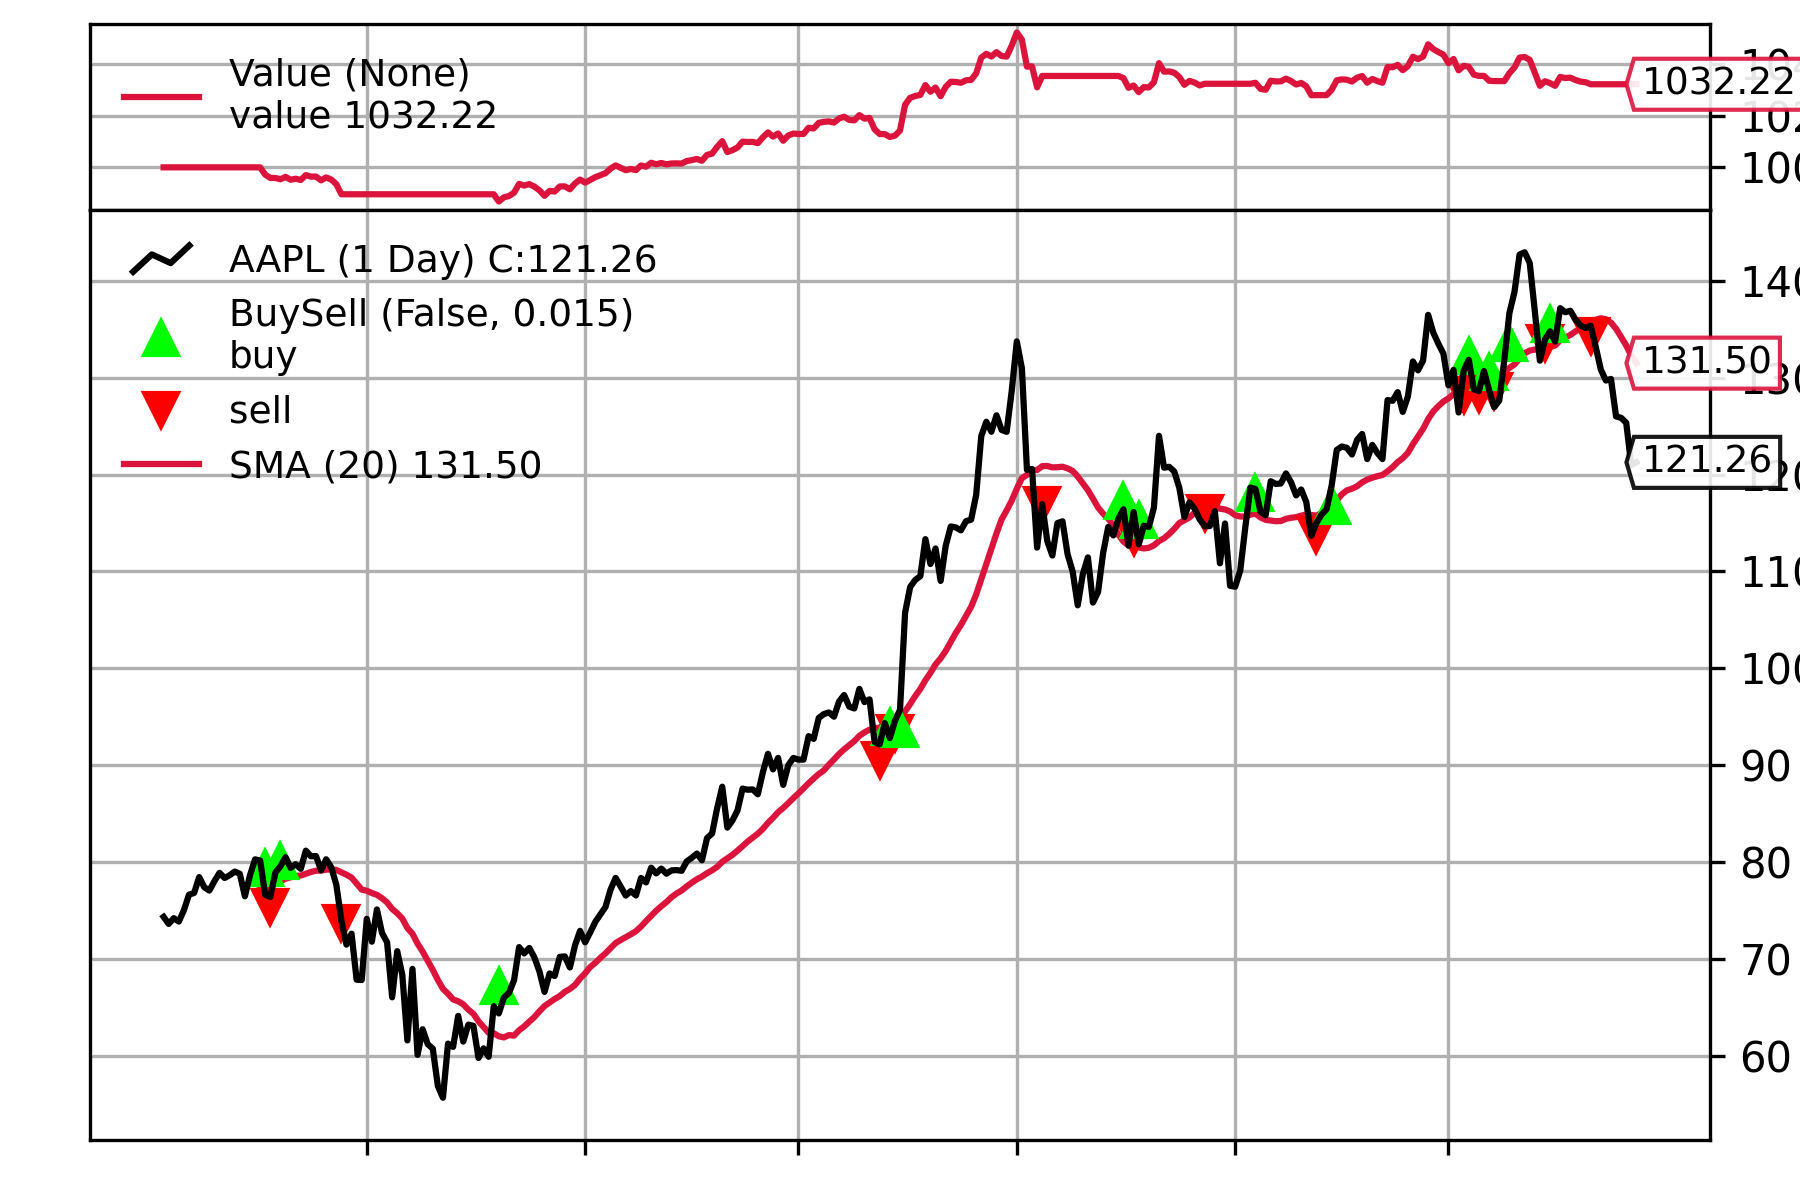

In [28]:

from google.colab import files
from IPython.display import Image
chart_file = 'result.png'
cerebro.plot(iplot=True, volume=False)[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())

#cerebro.plot(iplot=True, volume=False)